In [1]:
from joblib import Memory
import sklearn.datasets as sd
from sklearn import svm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mem = Memory("./cache")

In [4]:
filelist = ["./url_svmlight/Day%s.svm" % i for i in range(0,121)]

In [5]:
@mem.cache
def get_data():
    data = sd.load_svmlight_files(filelist)
    return data

In [6]:
data = get_data()

In [7]:
data

[<16000x3231961 sparse matrix of type '<class 'numpy.float64'>'
 	with 1847536 stored elements in Compressed Sparse Row format>,
 array([-1., -1., -1., ..., -1., -1.,  1.]),
 <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
 	with 2304202 stored elements in Compressed Sparse Row format>,
 array([-1., -1., -1., ..., -1., -1., -1.]),
 <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
 	with 2300129 stored elements in Compressed Sparse Row format>,
 array([-1., -1.,  1., ...,  1.,  1.,  1.]),
 <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
 	with 2302278 stored elements in Compressed Sparse Row format>,
 array([ 1.,  1.,  1., ...,  1., -1., -1.]),
 <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
 	with 2298268 stored elements in Compressed Sparse Row format>,
 array([-1.,  1.,  1., ..., -1.,  1.,  1.]),
 <20000x3231961 sparse matrix of type '<class 'numpy.float64'>'
 	with 2305094 stored elements in Compressed Sparse Row format>,
 

In [8]:
days = []
for i in range(0, len(data)): 
    if i%2 ==0:
        days.append((data[i], data[i+1]))

121

In [9]:
days[0]

(<16000x3231961 sparse matrix of type '<class 'numpy.float64'>'
 	with 1847536 stored elements in Compressed Sparse Row format>,
 array([-1., -1., -1., ..., -1., -1.,  1.]))

In [10]:
day0 = days[0]
day1 = days[1]

(array([10037.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5963.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

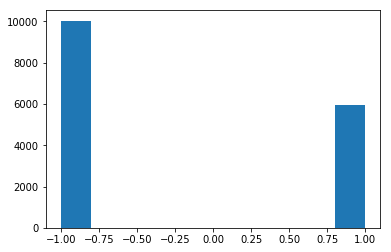

In [11]:
plt.hist(day0[1])

In [25]:
totalset = np.empty(0)

In [26]:
for day in days:
    totalset =np.append(totalset, day[1])

In [28]:
totalset

array([-1., -1., -1., ...,  1., -1., -1.])

(array([1603985.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  792145.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

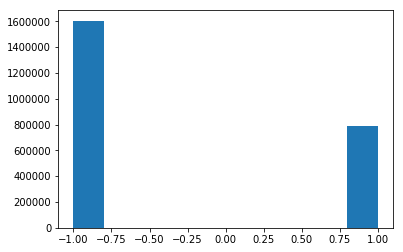

In [29]:
plt.hist(totalset)

## Testing Sklearn SVM classification

In [12]:
clf = svm.SVC(C=100)

### Training test: data of day 0

In [13]:
clf.fit(day0[0], day0[1])

/home/giordano/anaconda3/envs/da2019/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Predicting data of Day 1

In [15]:
clf.predict(day1[0])

array([-1., -1., -1., ..., -1., -1., -1.])

In [19]:
clf.score(day1[0], day1[1])

0.8705

## Testing PCA

In [1]:
from sklearn.decomposition import PCA

In [2]:
pca = PCA(n_components=0.8)

In [12]:
pca.fit(features)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

# Test for Day 1

In [24]:
print(day1[0][0])

  (0, 3)	0.0788382
  (0, 4)	0.124138
  (0, 5)	0.117647
  (0, 10)	0.285714
  (0, 15)	0.1
  (0, 16)	0.723562
  (0, 17)	0.688263
  (0, 18)	0.274458
  (0, 20)	0.142856
  (0, 21)	0.142857
  (0, 22)	0.142857
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 27)	1.0
  (0, 35)	1.0
  (0, 43)	1.0
  (0, 61)	1.0
  (0, 63)	1.0
  (0, 65)	1.0
  (0, 67)	1.0
  (0, 69)	1.0
  (0, 71)	1.0
  (0, 81)	1.0
  (0, 83)	1.0
  (0, 85)	1.0
  :	:
  (0, 155182)	1.0
  (0, 155193)	1.0
  (0, 155194)	1.0
  (0, 155195)	1.0
  (0, 155196)	1.0
  (0, 155197)	1.0
  (0, 155198)	1.0
  (0, 155199)	1.0
  (0, 155200)	1.0
  (0, 155201)	1.0
  (0, 155202)	1.0
  (0, 155203)	1.0
  (0, 155204)	1.0
  (0, 155205)	1.0
  (0, 155206)	1.0
  (0, 155207)	1.0
  (0, 155208)	1.0
  (0, 155209)	1.0
  (0, 155210)	1.0
  (0, 155211)	1.0
  (0, 155212)	1.0
  (0, 1028503)	1.0
  (0, 2062402)	1.0
  (0, 3065540)	1.0
  (0, 3124062)	1.0


In [10]:
print(len(day1[1]))

20000


In [10]:
pd.DataFrame(day1[1])

,0
0,-1.0
1,-1.0
2,-1.0
3,1.0
4,-1.0
5,1.0
6,-1.0
7,1.0
8,-1.0
9,-1.0


In [11]:
print(day1[0])

  (0, 3)	0.0788382
  (0, 4)	0.124138
  (0, 5)	0.117647
  (0, 10)	0.285714
  (0, 15)	0.1
  (0, 16)	0.723562
  (0, 17)	0.688263
  (0, 18)	0.274458
  (0, 20)	0.142856
  (0, 21)	0.142857
  (0, 22)	0.142857
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 27)	1.0
  (0, 35)	1.0
  (0, 43)	1.0
  (0, 61)	1.0
  (0, 63)	1.0
  (0, 65)	1.0
  (0, 67)	1.0
  (0, 69)	1.0
  (0, 71)	1.0
  (0, 81)	1.0
  (0, 83)	1.0
  (0, 85)	1.0
  :	:
  (19999, 155193)	1.0
  (19999, 155194)	1.0
  (19999, 155195)	1.0
  (19999, 155196)	1.0
  (19999, 155197)	1.0
  (19999, 155198)	1.0
  (19999, 155199)	1.0
  (19999, 155200)	1.0
  (19999, 155201)	1.0
  (19999, 155202)	1.0
  (19999, 155203)	1.0
  (19999, 155204)	1.0
  (19999, 155205)	1.0
  (19999, 155206)	1.0
  (19999, 155207)	1.0
  (19999, 155208)	1.0
  (19999, 155209)	1.0
  (19999, 155210)	1.0
  (19999, 155211)	1.0
  (19999, 155212)	1.0
  (19999, 424434)	1.0
  (19999, 1135228)	1.0
  (19999, 2120931)	1.0
  (19999, 2186470)	1.0
  (19999, 2223935)	1.0


(array([13192.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  6808.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

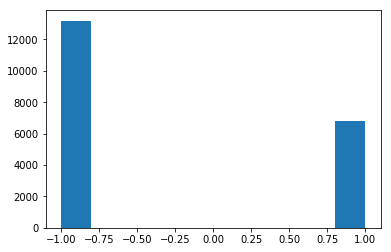

In [13]:
plt.hist(day1[1])